In [19]:
## As we can see resolution of images in our dataset is diffrent.

In [20]:
# print the epoch number to know which iteration number we are in
num_epochs= 5
for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

Epoch 1/5
----------
Epoch 2/5
----------
Epoch 3/5
----------
Epoch 4/5
----------
Epoch 5/5
----------


In [33]:
# Define a function to train our model
def train_model(model, criterion, optimizer, scheduler, batch_szie, num_epochs):
    # The number of epochs is a hyperparameter that defines 
    # the number times that the learning algorithm will work through the entire training dataset
    since = time.time() 
# Before defining a function to train our model, I will clarify each line of code separately
# Copy weights and biases of the pre-trained model into our model. By using transfer learning, the model parameters start with already-good initial values that only need some small 
# modifications to be better curated toward the new task
# We used the pre-trained model to re-purposed to our related task. 
   
    best_model_wts = copy.deepcopy(model.state_dict()) # Copy weights and biases of the pre-trained model into our model
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step() ## Adjust the learning rate based on the number of epochs
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
                
# Set the initial value of variables 
            best_acc = 0.0
            train_acc= list()
            valid_acc= list()
            running_loss = 0.0
            running_corrects = 0
            running_prec= 0.0
            running_rec = 0.0
            running_f1  = 0.0

            # Iterate over data.
            cur_batch_ind= 0
            for inputs, labels in dataloaders[phase]:
                print(cur_batch_ind,"batch inputs shape:", inputs.shape)
                print(cur_batch_ind,"batch label shape:", labels.shape)
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'): ## It makes sure to clear the intermediate values
                    ## for evaluation, which are needed to backpropagate during training, 
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1) # Returns the maximum value of all elements in the input tensor
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step() # hold the current state and will update the parameters based on the computed gradient

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                cur_acc= torch.sum(preds == labels.data).double()/batch_szie
                cur_batch_ind +=1
                print("\npreds:", preds)
                print("label:", labels.data)
                print("%d-th epoch, %d-th batch (size=%d), %s acc= %.3f \n" %(epoch+1, cur_batch_ind, len(labels), phase, cur_acc ))
                
                if phase=='train':
                    train_acc.append(cur_acc) ## append all the accuracy related to each epoch
                    print("len_train_acc=", len(train_acc))
                else:
                    valid_acc.append(cur_acc)
                    print("len_valid_acc=", len(valid_acc))
            ## calculation of accuracy for validation data   
           
            epoch_loss= running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f} \n\n'.format(
                phase, epoch_loss, epoch_acc))
            #plt.plot(range(n),epoch_acc)
   # plt.ylabel('Accuracy')
   # plt.xlabel('Epoch')
    #plt.title("Accuracy")
    #plt.legend(["Training Accuracy"])
    #plt.show()

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_epoch= epoch
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc= %.3f at Epoch: %d' %(best_acc,best_epoch) )
    
   # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_acc, valid_acc
   # plot the training accuracy
    

## Visualize the model

In [34]:
def visualize_model(model, num_images= 8):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images/8, 8, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)




In [35]:
#### load the first model Reznet18

model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False ## All new operations in the torch.set_grad_enabled(False) block won’t require gradients. 
    ## However, the model parameters will still require gradients.
    
    # Parameters of newly constructed modules have requires_grad=True by default   

num_ftrs = model_conv.fc.in_features        
model_conv.fc = nn.Linear(num_ftrs, 2)

criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr= 0.0001, momentum= 0.9)  

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

## Calling train_model function

In [37]:
if __name__ == "__main__":
    
    model_conv, train_acc, valid_acc = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, 10, 3)
    model_conv.eval()
    torch.save(model_conv, './covid_resnet18_epoch%d.pt' %100)

Epoch 1/3
----------
0 batch inputs shape: torch.Size([20, 3, 224, 224])
0 batch label shape: torch.Size([20])

preds: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
label: tensor([1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
1-th epoch, 1-th batch (size=20), train acc= 0.200 

len_train_acc= 1
1 batch inputs shape: torch.Size([20, 3, 224, 224])
1 batch label shape: torch.Size([20])

preds: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
label: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
1-th epoch, 2-th batch (size=20), train acc= 0.000 

len_train_acc= 2
2 batch inputs shape: torch.Size([20, 3, 224, 224])
2 batch label shape: torch.Size([20])

preds: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
label: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
1-th epoch, 3-th batch (size=20), train acc= 0.000 

len_train_acc= 3
3 batch inputs shape: torch.Size([20, 3,

In [38]:
end_time= time.time()
print("total_time tranfer learning=", end_time - start_time) 

total_time tranfer learning= 85193.48522377014


In [ ]:
# load second model Resnet 50
model_conv = torchvision.models.resnet50(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False ## All new operations in the torch.set_grad_enabled(False) block won’t require gradients. 
    ## However, the model parameters will still require gradients.
    
    # Parameters of newly constructed modules have requires_grad=True by default   

num_ftrs = model_conv.fc.in_features        
model_conv.fc = nn.Linear(num_ftrs, 2)

criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr= 0.0001, momentum= 0.9)  

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

<ipython-input-34-3ba343e17acf>:17: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = plt.subplot(num_images/8, 8, images_so_far)


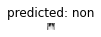

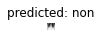

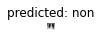

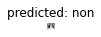

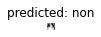

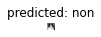

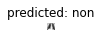

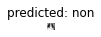

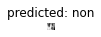

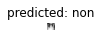

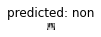

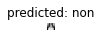

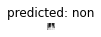

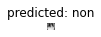

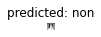

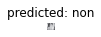

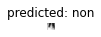

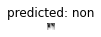

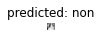

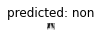

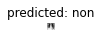

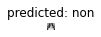

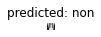

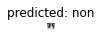

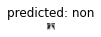

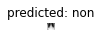

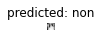

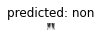

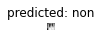

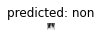

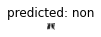

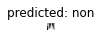

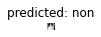

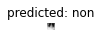

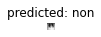

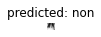

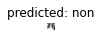

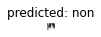

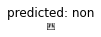

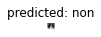

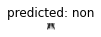

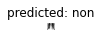

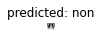

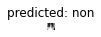

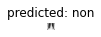

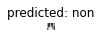

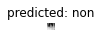

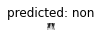

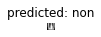

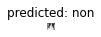

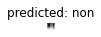

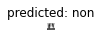

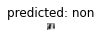

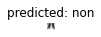

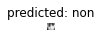

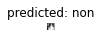

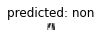

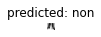

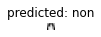

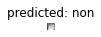

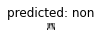

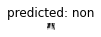

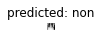

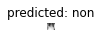

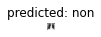

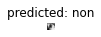

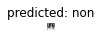

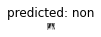

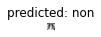

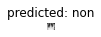

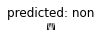

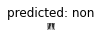

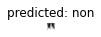

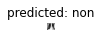

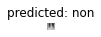

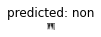

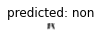

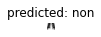

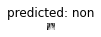

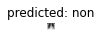

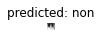

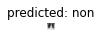

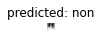

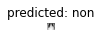

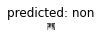

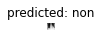

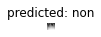

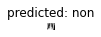

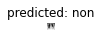

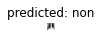

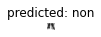

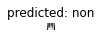

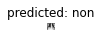

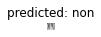

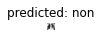

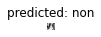

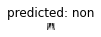

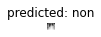

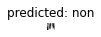

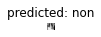

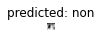

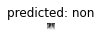

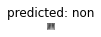

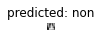

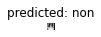

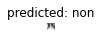

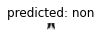

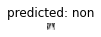

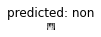

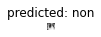

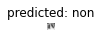

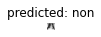

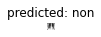

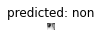

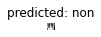

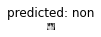

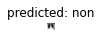

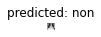

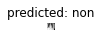

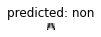

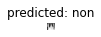

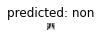

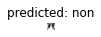

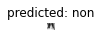

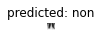

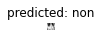

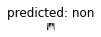

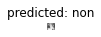

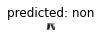

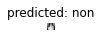

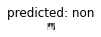

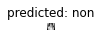

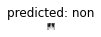

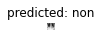

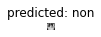

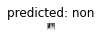

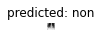

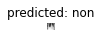

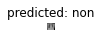

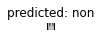

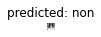

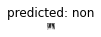

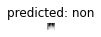

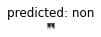

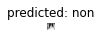

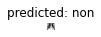

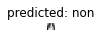

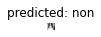

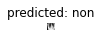

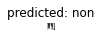

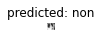

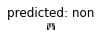

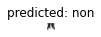

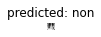

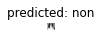

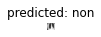

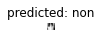

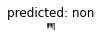

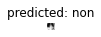

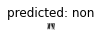

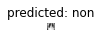

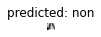

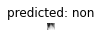

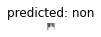

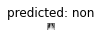

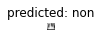

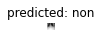

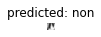

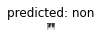

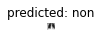

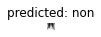

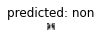

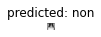

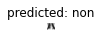

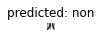

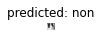

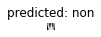

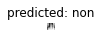

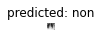

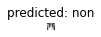

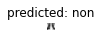

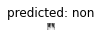

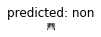

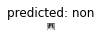

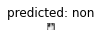

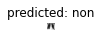

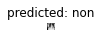

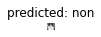

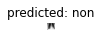

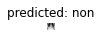

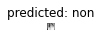

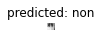

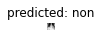

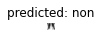

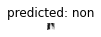

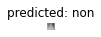

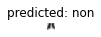

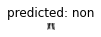

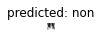

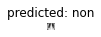

In [39]:
visualize_model(model_conv,num_images= 200)